# Schrödinger Equation Solver: Larmor precession

Author: C. Staufenbiel, 2022

### Introduction

This notebook guides you through the process of setting up a Schrödinger 
equation in QuTiP and using the corresponding solver to obtain the time 
evolution. We will investigate the example of the Larmor precession to 
explore the functionality of [`qutip.sesolve()`](https://qutip.org/docs/latest/apidoc/functions.html?highlight=sesolve#module-qutip.sesolve).

You can also find more on time evolutions with QuTiP [here](https://qutip.org/docs/latest/guide/guide-dynamics.html).

### Setup

First thing is to import the required functions, classes and modules.

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import qutip
from qutip import Bloch, QobjEvo, basis, sesolve, sigmax, sigmay, sigmaz, mesolve
from IPython.display import display, Math, Latex

%matplotlib inline

We setup a arbitrary qubit state, which is in a superposition of the two qubit states. We use the `qutip.Bloch` class to visualize the state on the Bloch sphere. $\rangle$

<IPython.core.display.Math object>

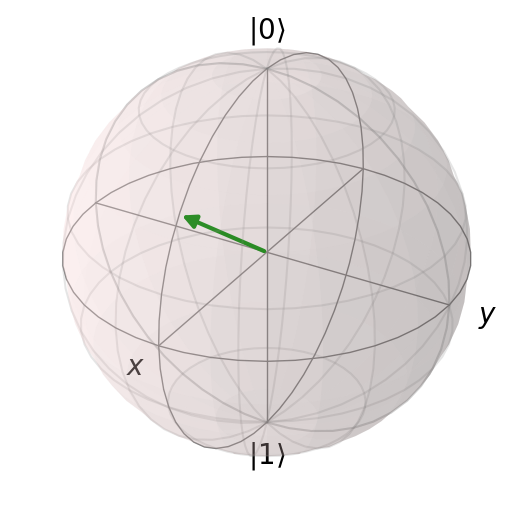

In [2]:
psi = (2.0 * basis(2, 0) + basis(2, 1)).unit()
print('======================')
display(Math(r'2 |0\rangle + |1\rangle'))

b = Bloch()
b.add_states(psi)
b.show()

### Simulation with constant magnetic field

Let's define a simple Hamiltonian and use `qutip.sesolve` to solve the
Schrödinger equation. The Hamiltonian describes a constant magnetic field 
along the z-axis. We can describe this magnetic field by the corresponding 
Pauli matrix, which is defined as `qutip.sigmaz()` in QuTiP.

To solve the Schrödinger equation for this particular Hamiltonian, we have to pass the Hamiltonian, the initial state, the times for which we want to simulate the system, and a set of observables that we evaluate at these times.

Here, we are for example interested in the time evolution of the expectation value for $\sigma_y$. We pass these properties to `sesolve` in the following.

Arguments:

```python
sesolve(H, psi0, tlist,             e_ops=None, args=None, options=None, progress_bar=None, _safe_mode=True)

mesolve(H, rho0, tlist, c_ops=None, e_ops=None, args=None, options=None, progress_bar=None, _safe_mode=True)
```

In [17]:
# simulate the unitary dynamics
H = sigmaz()
times = np.linspace(0, 10, 500)
result = sesolve(H, psi, times, [sigmay()])

`result.expect` holds the expecation values for the times that we passed to `sesolve`. `result.expect` is a two dimensional array, where the first dimension refers to the different expectation operators that we passed to `sesolve` before. 

Above we passed `sigmay()` as the only expectation operator and therefore we can access its values by `result.expect[0]`. Below we plot the evolution of the expecation value.

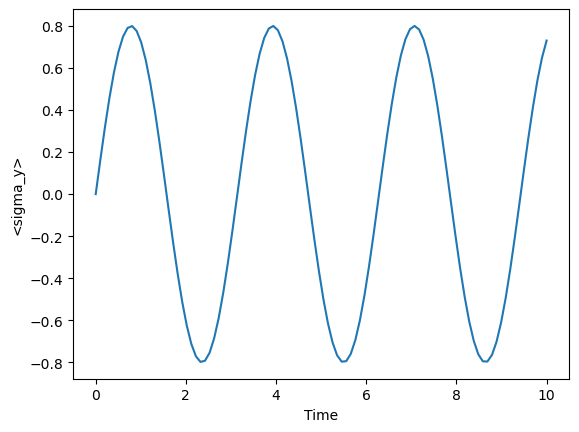

In [4]:
plt.plot(times, result.expect[0])
plt.xlabel("Time"), plt.ylabel("<sigma_y>")
plt.show()

Above we gave `sigmay()` as an operator to `sesolve` to directly calculate it's expectation value. If we pass an empty list at this argument to `sesolve` it will return the quantum state of the system for each time step in `times`. We can access the states by `result.states` and use them for example to plot the states on the Bloch sphere to see the precession. If the solver take a long time to run, it is also a good idea to return the states, so you can calculate different things, without specifying before the calculation.

In [5]:
def _(self, states):
    """
    Add a curve representing the evolution of a state.
    Evolution: green → yellow.
    """
    import matplotlib
    length = len(states)
    nrm = matplotlib.colors.Normalize(0,length)
    colors = matplotlib.cm.summer(nrm(range(length))) # options: cool, summer, winter, autumn etc.

    # Customize sphere properties
    self.point_color = list(colors) # options: 'r', 'g', 'b' etc.
    self.point_marker = ['o']
    self.point_size = [30]

    # Use the line below to add states as points
    self.add_states(states, kind='point')

    # Use the line below to add states as arcs
    # for i in range(len(states) - 1):
    #     self.add_arc(states[i], states[i+1], color=colors[i], fmt='')
        
    self.vector_color = [colors[0], colors[-1]]
    self.add_states(states[0])
    self.add_states(states[-1])
Bloch.add_evolving_states = _

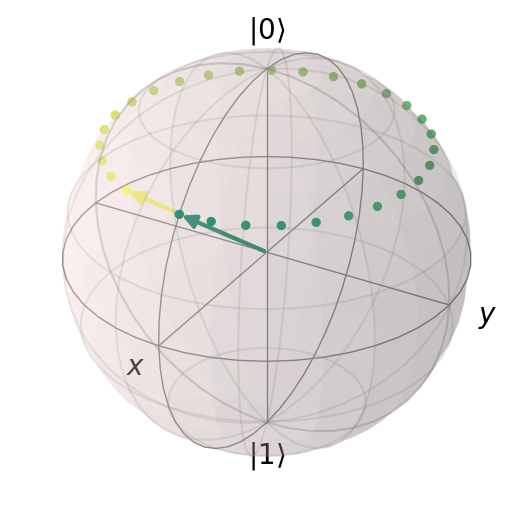

In [6]:
res = sesolve(H, psi, times, [])
b = Bloch()
b.add_evolving_states(res.states[:30])
b.show()

## Simulation with varying magnetic field

Above we passed a constant Hamiltonian to `sesolve`. In QuTiP these constant operators are represented by `Qobj`. However, `sesolve` can also take time-dependent operators as an argument, which are represented by [`QobjEvo`](https://qutip.org/docs/latest/apidoc/classes.html?highlight=qobjevo#qutip.QobjEvo) in QuTiP. In this section we define the magnetic field with a linear and a periodic field strength, and observe the changes in the expecation value of $\sigma_y$.
You can find more information on `QobjEvo` in [this notebook](https://nbviewer.jupyter.org/github/qutip/qutip-notebooks/blob/master/examples/qobjevo.ipynb).

We start by defining two functions for the field strength of the magnetic field. To be passed on to `QobjEvo` the functions need two arguments: the times and optional arguments.


In [18]:
def linear(t, args):
    return 0.3 * t


def periodic(t, args):
    return np.cos(0.5 * t)


# Define QobjEvos
H_lin = QobjEvo([[sigmaz(), linear]], tlist=times)
H_per = QobjEvo([[sigmaz(), periodic]], tlist=times)

We can now continue as in the previous section and use `sesolve` to solve the Schrödinger equation.

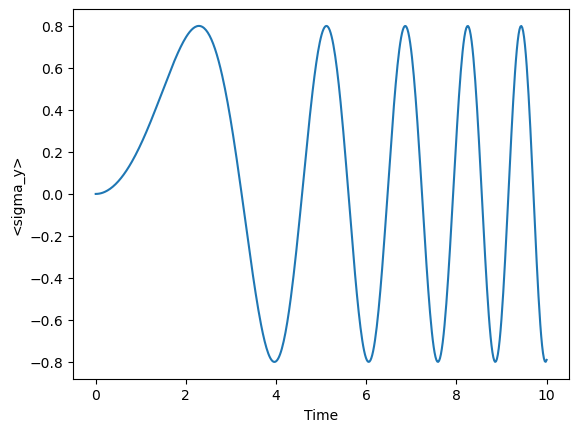

In [43]:
times = np.linspace(0, 10, 500)

result_lin = sesolve(H_lin, psi, times, [sigmay()])

# Plot <sigma_y> for linear increasing field strength
plt.plot(times, result_lin.expect[0])
plt.xlabel("Time"), plt.ylabel("<sigma_y>")
plt.show()

Evolution till time: t = 4.008016032064128


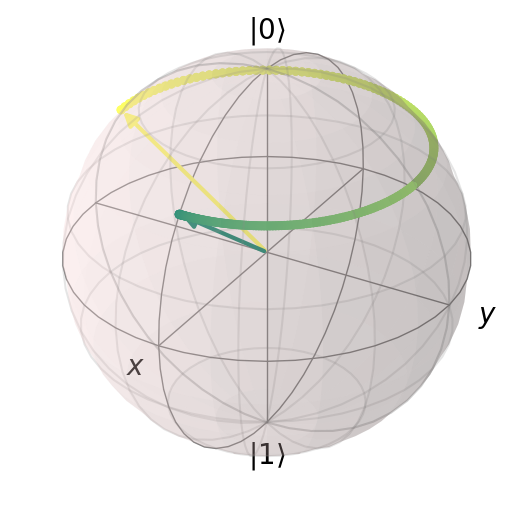

In [44]:
result_lin = sesolve(H_lin, psi, times)

b = Bloch()
b.add_evolving_states(result_lin.states[:200])

print(f'Evolution till time: t = {times[200]}')
b.show()

We can see that the frequency of the Larmor precession increases with the time. This is a direct result of the time-dependent Hamiltonian. We can generate the same plot for the periodically varying field strength.

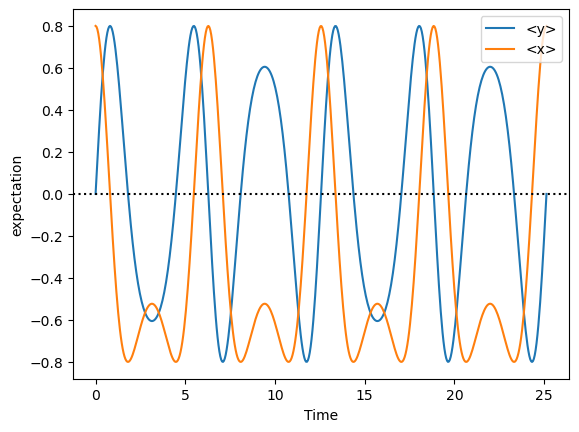

In [38]:
times = np.linspace(0, 8*np.pi, 500)
result_per = sesolve(H_per, psi, times, [sigmay(), sigmax()])

plt.plot(times, np.array(result_per.expect).T, label=['<y>', '<x>'])
plt.legend()
plt.axhline(0, color='k', linestyle=':')
plt.xlabel("Time"), plt.ylabel("expectation")
plt.show()

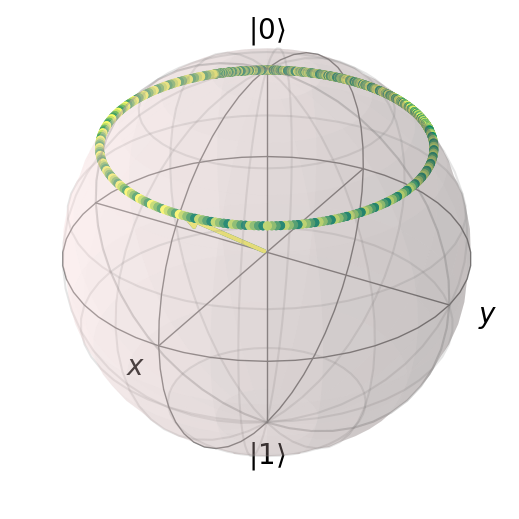

In [39]:
result_per = sesolve(H_per, psi, times)

b = Bloch()
b.add_evolving_states(result_per.states[:])
b.show()

In [46]:
def animate_bloch(states, filename='', duration=0.1):

    import numpy as np
    import matplotlib
    from tqdm import tqdm
    import imageio.v2 as imageio
    import os
    from qutip import Bloch

    b = Bloch()
    b.vector_color = ['r']
    b.view = [-40,30]
    images=[]
    try:
        length = len(states)
    except:
        length = 1
        states = [states]
    ## normalize colors to the length of data ##
    nrm = matplotlib.colors.Normalize(0,length)
    colors = matplotlib.cm.summer(nrm(range(length))) # options: cool, summer, winter, autumn etc.

    ## customize sphere properties ##
    b.point_color = list(colors) # options: 'r', 'g', 'b' etc.
    b.point_marker = ['o']
    b.point_size = [30]
    
    temp_file = 'temp_file.png'
    for i in tqdm(range(length)):
        b.clear()
        b.add_states(states[i])
        b.add_states(states[:(i+1)],'point')
        b.save(temp_file)
        images.append(imageio.imread(temp_file))
    os.remove(temp_file)
    
    filename = 'bloch_anim.gif' if not filename else filename
    imageio.mimsave(filename, images, duration=duration)

In [ ]:
animate_bloch(result_per.states[::20], 'periodic_drive.gif', duration=3)

### Conclusion
We can use `sesolve` to solve unitary time evolutions. This is not only 
limited to constant Hamiltonians, but we can also make use of time-dependent Hamiltonians using `QobjEvo`. 

### About

In [9]:
qutip.about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Jake Lishman and Simon Cross.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      4.7.0
Numpy Version:      1.22.4
Scipy Version:      1.8.1
Cython Version:     None
Matplotlib Version: 3.5.2
Python Version:     3.10.4
Number of CPUs:     8
BLAS Info:          Generic
OPENMP Installed:   False
INTEL MKL Ext:      False
Platform Info:      Windows (AMD64)
Installation path:  C:\ProgramData\miniconda3\envs\de\lib\site-packages\qutip
Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.ci

### Testing

This section can include some tests to verify that the expected outputs are
generated within the notebook. We put this section at the end of the notebook,
so it's not interfering with the user experience. Please, define the tests
using `assert`, so that the cell execution fails if a wrong output is generated.

In [10]:
assert np.allclose(result.expect[0][0], 0)
assert np.allclose(result_lin.expect[0][0], 0)
assert np.allclose(result_per.expect[0][0], 0)
assert 1 == 1